In [151]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import pickle
import glob
import time

C:\Users\lisas\AppData\Local\Temp\ipykernel_10368\2716602987.py:10: DeprecationWarning: Please import `label` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.measurements import label


In [152]:
vehicles_dir = 'data/train/car/'
non_vehicles_dir = 'data/train/non_car/'

car_images = list(glob.iglob(vehicles_dir + '/**/*.jpg', recursive=True))
noncar_images = list(glob.iglob(non_vehicles_dir + '/**/*.jpg', recursive=True))
print(len(car_images), len(noncar_images))

50442 42000


In [153]:
import random
random.seed(42)

sample_size = 1000 # reduce dataset
car_images = random.sample(car_images, min(len(car_images), sample_size))
noncar_images = random.sample(noncar_images, min(len(noncar_images), sample_size))

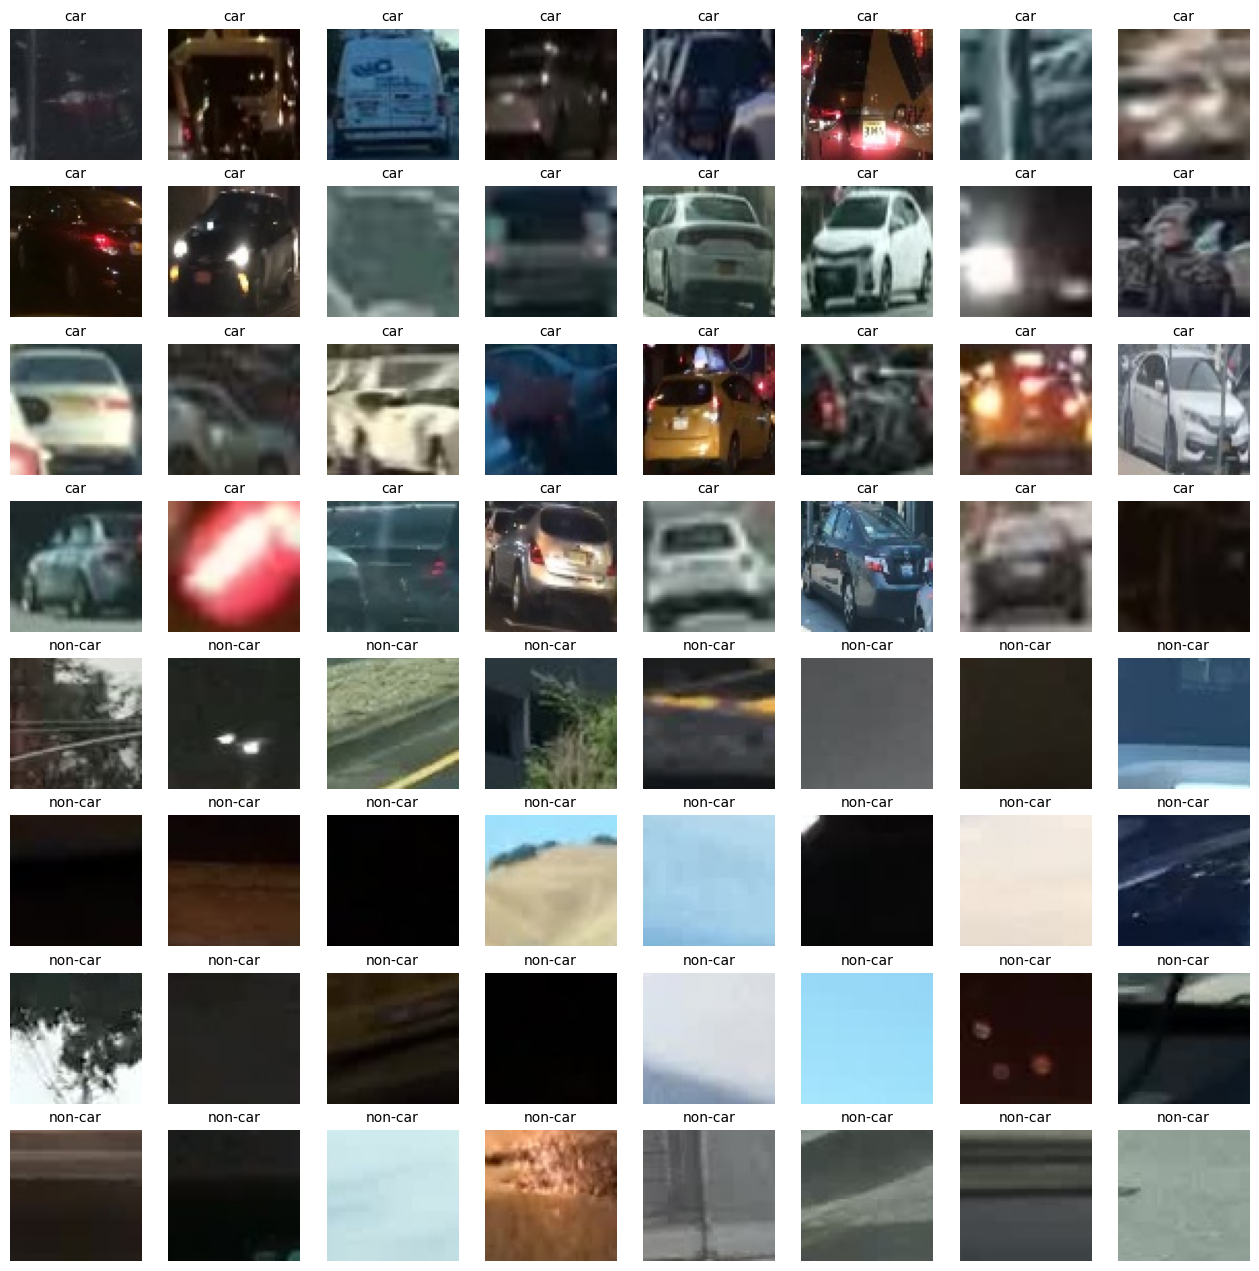

In [154]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    img = cv2.imread(car_images[random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
    
for i in np.arange(32,64):
    img = cv2.imread(noncar_images[random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('non-car', fontsize=10)
    axs[i].imshow(img)

### Histogram of Oriented Gradients 

In [155]:
HOG_PARAMS = {
    'orientations': 9,
    'pixels_per_cell': (4, 4),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys',
    'transform_sqrt': False 
}
# HOG_PARAMS = {
#     'orientations': 11,
#     'pixels_per_cell': (16,16),
#     'cells_per_block': (2, 2),
#     'block_norm': 'L2-Hys',
#     'transform_sqrt': True 
# }

Text(0.5, 1.0, 'Non-Car HOG')

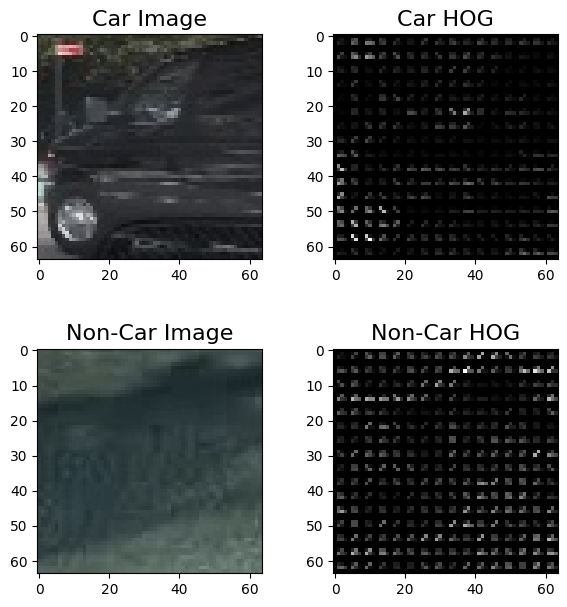

In [156]:
car_img = mpimg.imread(car_images[1])
noncar_img = mpimg.imread(noncar_images[0])

_, car_dst = hog(car_img[:,:,2], **HOG_PARAMS, visualize=True, feature_vector=True)
_, noncar_dst = hog(noncar_img[:,:,2], **HOG_PARAMS, visualize=True, feature_vector=True)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

In [157]:
def color_conversion(cspace, image):
    if cspace == 'HSV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif cspace == 'LUV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif cspace == 'HLS':
        return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    elif cspace == 'YUV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    elif cspace == 'YCrCb':
        return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

In [158]:
def extract_features(imgs, HOG_PARAMS, cspace='RGB', hog_channel='ALL'):
    # Create a list to append feature vectors to
    features = []

    for file in imgs:

        image = mpimg.imread(file)

        if cspace != 'RGB':
            feature_image = color_conversion(cspace, image)
        else: feature_image = np.copy(image)      

        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(hog(feature_image[:,:,channel], 
                                    **HOG_PARAMS, 
                                    visualize=False, feature_vector=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = hog(feature_image[:,:,hog_channel], **HOG_PARAMS,
                               visualize=False, feature_vector=True)

        features.append(hog_features)

    return features

In [159]:
# Feature extraction parameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_features(car_images, HOG_PARAMS, cspace=colorspace,
                        hog_channel=hog_channel)
noncar_features = extract_features(noncar_images, HOG_PARAMS, cspace=colorspace,
                        hog_channel=hog_channel)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)  

# Fit a per-column scaler - this will be necessary if combining different types of features (HOG + color_hist/bin_spatial)
#X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
#scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print('Using:',HOG_PARAMS)
print('Feature vector length:', len(X_train[0]))


21.46 Seconds to extract HOG features...
Using: {'orientations': 9, 'pixels_per_cell': (4, 4), 'cells_per_block': (2, 2), 'block_norm': 'L2-Hys', 'transform_sqrt': False}
Feature vector length: 24300


### Train a Classifier

In [160]:
from sklearn.metrics import classification_report, accuracy_score

svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

preds = svc.predict(X_test)
acc = accuracy_score(y_test, preds)
print(f"Accuracy: {acc:.4f}")
print(classification_report(y_test, preds))

1.15 Seconds to train SVC...
Accuracy: 0.8800
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88       201
         1.0       0.88      0.88      0.88       199

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400



### Detecting Cars in an Image

In [161]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, HOG_PARAMS, spatial_size, hist_bins, show_all_rectangles=False):
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        ctrans_tosearch = color_conversion(cspace, img_tosearch)
    else: ctrans_tosearch = np.copy(img_tosearch)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (int(imshape[1]/scale), int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // HOG_PARAMS["pixels_per_cell"][0])+1  #-1
    nyblocks = (ch1.shape[0] // HOG_PARAMS["pixels_per_cell"][0])+1  #-1 
    # nfeat_per_block = HOG_PARAMS["orientations"]*HOG_PARAMS["cells_per_block"][0]**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // HOG_PARAMS["pixels_per_cell"][0])-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = hog(ch1, **HOG_PARAMS, feature_vector=False)   
    if hog_channel == 'ALL':
        hog2 = hog(ch2, **HOG_PARAMS, feature_vector=False)
        hog3 = hog(ch3, **HOG_PARAMS, feature_vector=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*HOG_PARAMS["pixels_per_cell"][0]
            ytop = ypos*HOG_PARAMS["pixels_per_cell"][0]
            
            ################ ONLY FOR BIN_SPATIAL AND COLOR_HIST ################

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            
            ######################################################################
            test_features = hog_features.reshape(1, -1)
            test_features = np.nan_to_num(test_features)
            confidence = svc.decision_function(test_features)[0]
            
            if confidence > 1 or show_all_rectangles:
                xbox_left = int(xleft*scale)
                ytop_draw = int(ytop*scale)
                win_draw = int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

### Testing on images

In [162]:
import pandas as pd
import os
import matplotlib.image as mpimg

TEST_CSV = '../data/labels/test_labels.csv'
IMG_DIR = "../data/bdd100k_images_100k/100k/train"

df = pd.read_csv(TEST_CSV)
unique_images = df['image'].unique()

test_images = []

for i, filename in enumerate(unique_images):
    img_path = os.path.join(IMG_DIR, filename+'.jpg')    
    if os.path.exists(img_path):
        test_images.append(mpimg.imread(img_path))
    else:
        print(f"Warning: {filename} not found in {IMG_DIR}")


In [163]:
test_img = test_images[1]

ystart = 360
ystop = 656
scale = 1.5
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, HOG_PARAMS, None, None)

print(len(rectangles), 'rectangles found in image')

27 rectangles found in image


### Method to Draw Rectangles on Image

In [164]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=4):
    imcopy = np.copy(img)
    random_color = False
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

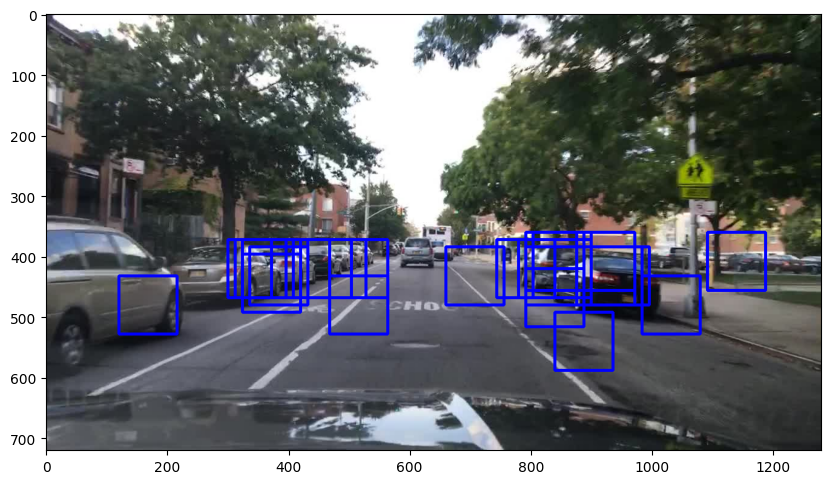

In [165]:
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

Number of boxes:  1196


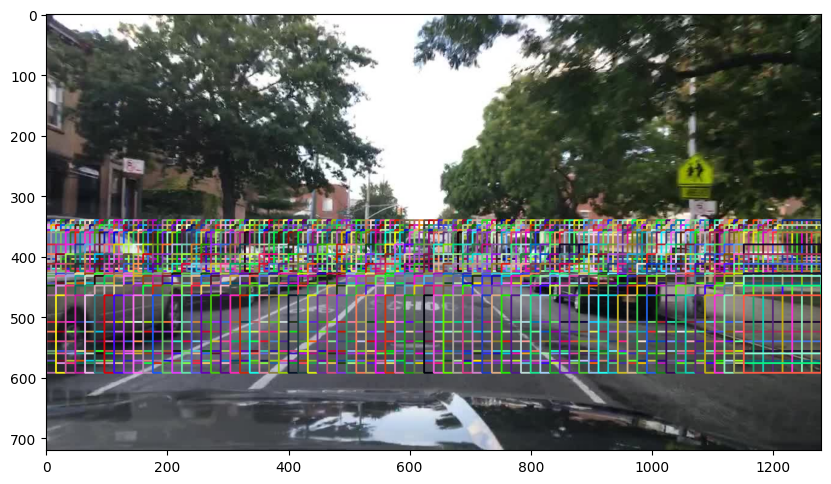

In [166]:
rects = []

ystart = 340
ystop = 425
scale = 1
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       HOG_PARAMS, None, None, show_all_rectangles=True))
ystart = 360
ystop = 430
scale = 1
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       HOG_PARAMS, None, None, show_all_rectangles=True))


ystart = 380
ystop = 580
scale = 2.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       HOG_PARAMS, None, None, show_all_rectangles=True))
ystart = 432
ystop = 600
scale = 2.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       HOG_PARAMS, None, None, show_all_rectangles=True))


rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  53


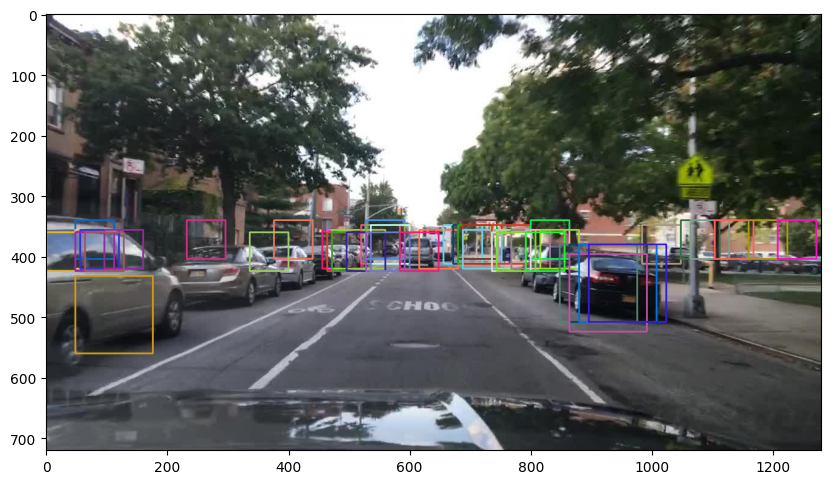

In [167]:
rects = []

ystart = 340
ystop = 425
scale = 1
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                      HOG_PARAMS, None, None))
ystart = 360
ystop = 430
scale = 1
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       HOG_PARAMS, None, None))

ystart = 380
ystop = 580
scale = 2.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       HOG_PARAMS, None, None))
ystart = 432
ystop = 600
scale = 2.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       HOG_PARAMS, None, None))


rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

### Heatmap
This method produces a heat map based on rectangle locations (additive with overlap).

In [168]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

8 cars found


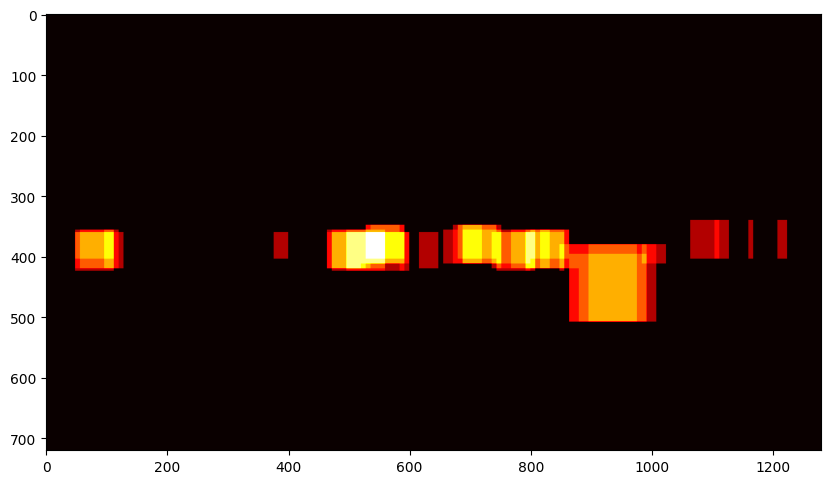

In [169]:
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
heatmap_img = apply_threshold(heatmap_img, 1)

labels = label(heatmap_img)

plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
print(labels[1], 'cars found')

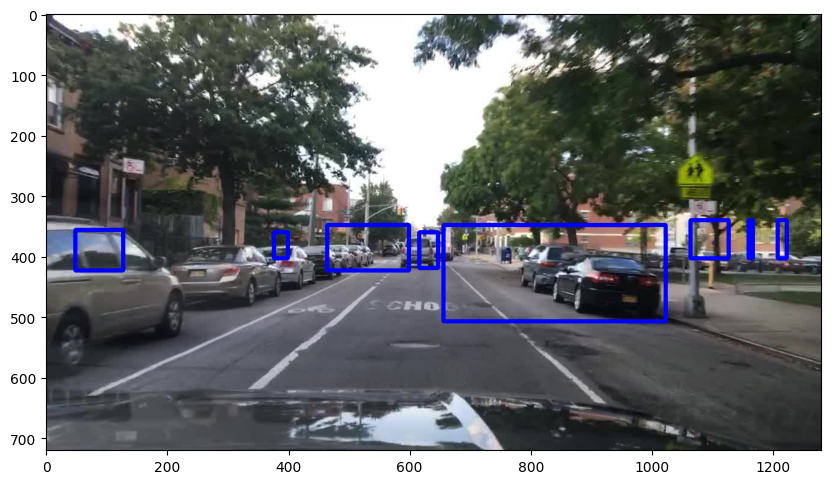

In [170]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img, rects

draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

## Putting all together

In [171]:
def process_frame(img):
    colorspace = 'YUV'
    hog_channel = 'ALL'

    rects = []

    ystart = 340
    ystop = 425
    scale = 1
    rects.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                        HOG_PARAMS, None, None))
    ystart = 360
    ystop = 430
    scale = 1
    rects.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                        HOG_PARAMS, None, None))
    ystart = 380
    ystop = 580
    scale = 2.0
    rects.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                        HOG_PARAMS, None, None))
    ystart = 432
    ystop = 600
    scale = 2.0
    rects.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                        HOG_PARAMS, None, None))

    rectangles = [item for sublist in rects for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img, heatmap_img, rects

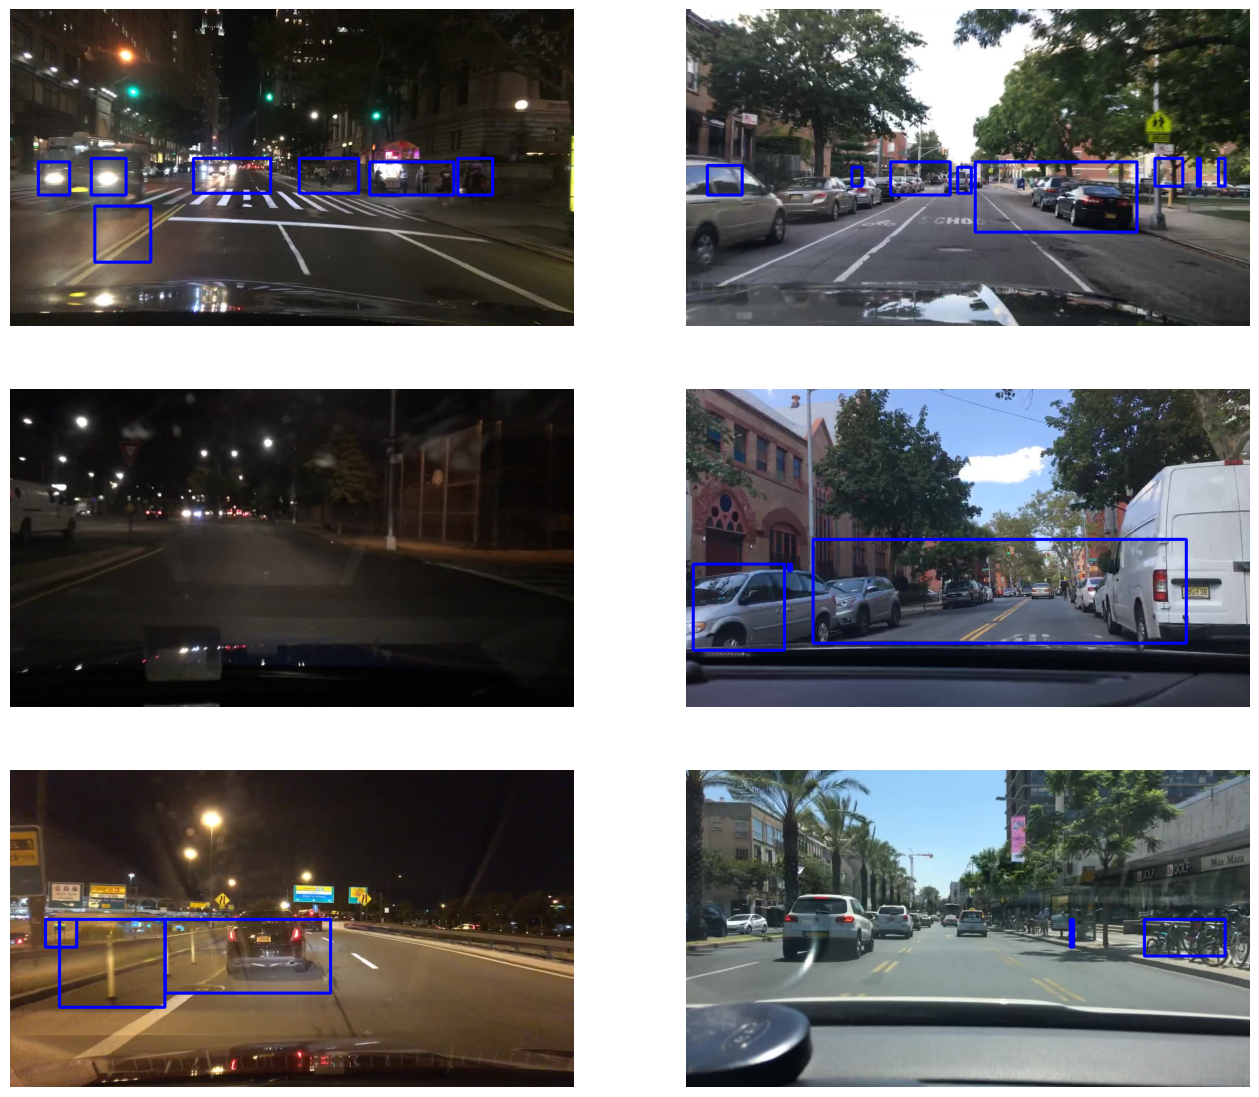

In [172]:
fig, axs = plt.subplots(3, 2, figsize=(16,14))
axs = axs.ravel()

for i, im in enumerate(test_images[:6]):
    axs[i].imshow(process_frame(im)[0])
    axs[i].axis('off')

## mAP

In [173]:
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def calculate_dataset_map(image_filenames):
    metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox')
    
    all_preds = []
    all_targets = []

    for filename in image_filenames:
        img_path = os.path.join(IMG_DIR, filename + '.jpg')
        if not os.path.exists(img_path): continue
        
        image = mpimg.imread(img_path)
        
        _, heatmap, pred_data = process_frame(image)
        
        if len(pred_data) > 0:
            p_boxes = []
            p_scores = []
            for rect in pred_data:
                x1, y1 = rect[0]
                x2, y2 = rect[1]
                p_boxes.append([x1, y1, x2, y2])
                
                score = np.max(heatmap[y1:y2, x1:x2]) if x2 > x1 and y2 > y1 else 0
                p_scores.append(score)
        else:
            p_boxes = []
            p_scores = []

        all_preds.append({
            'boxes': torch.tensor(p_boxes, dtype=torch.float32).reshape(-1, 4),
            'scores': torch.tensor(p_scores, dtype=torch.float32),
            'labels': torch.zeros(len(p_boxes), dtype=torch.int64)
        })

        gt_rows = df[(df['image'] == filename) & (df['category'] == 'car')]
        gt_boxes = gt_rows[['x1', 'y1', 'x2', 'y2']].values
        
        all_targets.append({
            'boxes': torch.tensor(gt_boxes, dtype=torch.float32).reshape(-1, 4),
            'labels': torch.zeros(len(gt_boxes), dtype=torch.int64)
        })

    metric.update(all_preds, all_targets)
    results = metric.compute()    
    
    return results

In [174]:
results = calculate_dataset_map(unique_images[:100])
display(results)

{'map': tensor(0.0032),
 'map_50': tensor(0.0115),
 'map_75': tensor(0.),
 'map_small': tensor(0.),
 'map_medium': tensor(0.0015),
 'map_large': tensor(0.0036),
 'mar_1': tensor(0.0021),
 'mar_10': tensor(0.0047),
 'mar_100': tensor(0.0047),
 'mar_small': tensor(0.),
 'mar_medium': tensor(0.0084),
 'mar_large': tensor(0.0075),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor(0, dtype=torch.int32)}